# Claude Hierarchical Mini Blog Post Writer Crew - Research with Human Input - CrewAI.ipynb


https://pypi.org/project/crewai/

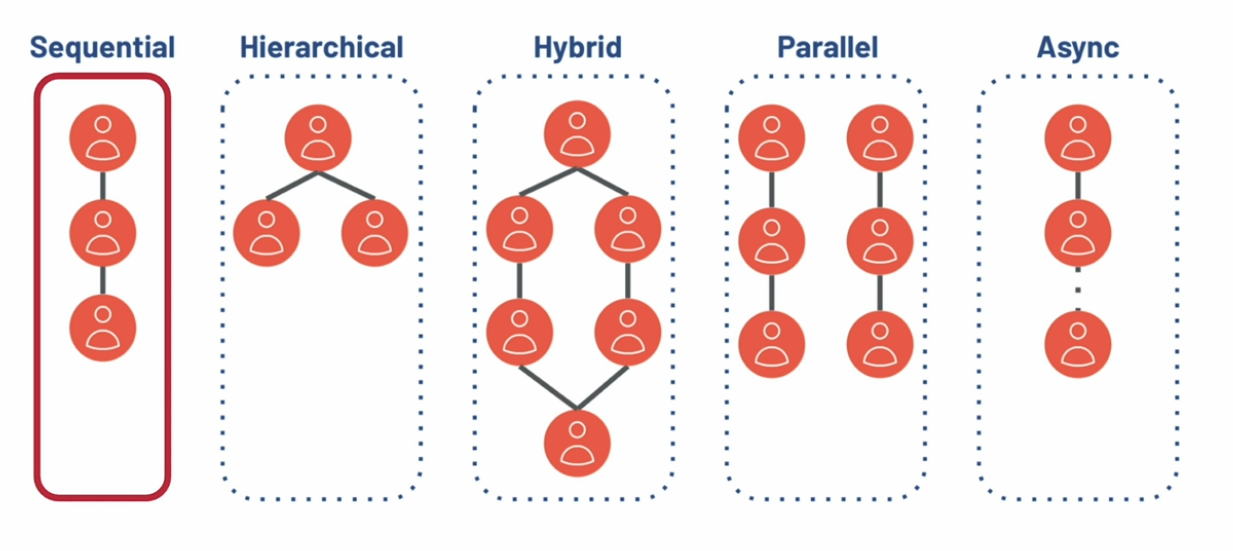

In [1]:
!pip install -qU crewai==0.28.8 crewai_tools==0.1.6 langchain_community==0.0.29

In [2]:
!pip show crewai

Name: crewai
Version: 0.28.8
Summary: Cutting-edge framework for orchestrating role-playing, autonomous AI agents. By fostering collaborative intelligence, CrewAI empowers agents to work together seamlessly, tackling complex tasks.
Home-page: https://crewai.com
Author: Joao Moura
Author-email: joao@crewai.com
License: 
Location: /home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages
Requires: appdirs, click, embedchain, instructor, langchain, openai, opentelemetry-api, opentelemetry-exporter-otlp-proto-http, opentelemetry-sdk, pydantic, python-dotenv, regex
Required-by: 


In [28]:
import os
from utils import get_bedrock_client, get_haiku_config, get_sonnet_config
from langchain_community.chat_models import BedrockChat  # Changed this import
from crewai import Agent, Task, Crew

In [13]:
bedrock_client = get_bedrock_client()
sonnet_config = get_sonnet_config()  # Using Sonnet config

# Create BedrockChat instance for CrewAI
llm = BedrockChat(
    client=bedrock_client,
    model_id="anthropic.claude-3-sonnet-20240229-v1:0",  # Updated model ID
    streaming=True,
    model_kwargs={
        "temperature": sonnet_config["temperature"],
        "top_p": sonnet_config["top_p"],
        "max_tokens": sonnet_config["max_tokens"],
        "anthropic_version": "bedrock-2023-05-31"
    }
)

# Set model name in environment if needed
os.environ["MODEL_NAME"] = "anthropic.claude-3-sonnet-20240229-v1:0"

## Utilities

In [14]:
import json  # Import the JSON module to parse JSON strings
from langchain_core.agents import AgentFinish

agent_finishes  = []

import json
from typing import Union, List, Tuple, Dict
from langchain.schema import AgentFinish


call_number = 0

def print_agent_output(agent_output: Union[str, List[Tuple[Dict, str]], AgentFinish], agent_name: str = 'Generic call'):
    global call_number  # Declare call_number as a global variable
    call_number += 1
    with open("crew_callback_logs.txt", "a") as log_file:
        # Try to parse the output if it is a JSON string
        if isinstance(agent_output, str):
            try:
                agent_output = json.loads(agent_output)  # Attempt to parse the JSON string
            except json.JSONDecodeError:
                pass  # If there's an error, leave agent_output as is

        # Check if the output is a list of tuples as in the first case
        if isinstance(agent_output, list) and all(isinstance(item, tuple) for item in agent_output):
            print(f"-{call_number}----Dict------------------------------------------", file=log_file)
            for action, description in agent_output:
                # Print attributes based on assumed structure
                print(f"Agent Name: {agent_name}", file=log_file)
                print(f"Tool used: {getattr(action, 'tool', 'Unknown')}", file=log_file)
                print(f"Tool input: {getattr(action, 'tool_input', 'Unknown')}", file=log_file)
                print(f"Action log: {getattr(action, 'log', 'Unknown')}", file=log_file)
                print(f"Description: {description}", file=log_file)
                print("--------------------------------------------------", file=log_file)

        # Check if the output is a dictionary as in the second case
        elif isinstance(agent_output, AgentFinish):
            print(f"-{call_number}----AgentFinish---------------------------------------", file=log_file)
            print(f"Agent Name: {agent_name}", file=log_file)
            agent_finishes.append(agent_output)
            # Extracting 'output' and 'log' from the nested 'return_values' if they exist
            output = agent_output.return_values
            # log = agent_output.get('log', 'No log available')
            print(f"AgentFinish Output: {output['output']}", file=log_file)
            # print(f"Log: {log}", file=log_file)
            # print(f"AgentFinish: {agent_output}", file=log_file)
            print("--------------------------------------------------", file=log_file)

        # Handle unexpected formats
        else:
            # If the format is unknown, print out the input directly
            print(f"-{call_number}-Unknown format of agent_output:", file=log_file)
            print(type(agent_output), file=log_file)
            print(agent_output, file=log_file)



In [15]:
from crewai import Crew, Agent, Task, Process
from langchain_community.tools import DuckDuckGoSearchRun

## Tools

In [16]:
from datetime import datetime
from random import randint
from langchain.tools import tool

@tool("save_content")
def save_content(task_output):
    """Useful to save content to a markdown file. Input is a string"""
    print('in the save markdown tool')
    # Get today's date in the format YYYY-MM-DD
    today_date = datetime.now().strftime('%Y-%m-%d')
    # Set the filename with today's date
    filename = f"{today_date}_{randint(0,100)}.md"
    # Write the task output to the markdown file
    with open(filename, 'w') as file:
        file.write(task_output)
        # file.write(task_output.result)

    print(f"Blog post saved as {filename}")

    return f"Blog post saved as {filename}, please tell the user we are finished"

In [17]:
import json
import os

import requests
from langchain.tools import tool

import os
from crewai import Agent, Task, Crew, Process
from langchain_community.tools import DuckDuckGoSearchRun
from langchain.agents import load_tools

search_tool = DuckDuckGoSearchRun()

# Loading Human Tools
human_tools = load_tools(["human"])

## Agents

In [18]:
from crewai import Agent

# Define your agents with roles and goals
topic_getter = Agent(
    role='A Senior customer communicator',
    goal='consult with the human customer to get the topic and areas of interest for doing the research',
    backstory="""As a top customer communicator at a renowned technology you have honed your skills
    in consulting with a customer to understand their needs and goals for what research is needed.""",
    verbose=True,
    allow_delegation=False,
    llm=llm,
    max_iter=5,
    memory=True,
    step_callback=lambda x: print_agent_output(x,"Senior Customer Agent"),
    tools= human_tools, # Passing human tools to the agent,
)


info_getter = Agent(
    role='AI Research Specialist',
    goal='Leverage advanced search techniques to surface the most relevant, credible, and impactful information on AI and data science breakthroughs',
    backstory="""As a top AI Research Specialist at a renowned technology
    research institute, you have honed your skills in crafting sophisticated
    search queries, filtering information from trusted sources, and synthesizing
    key insights. You have the ability to take a topic suggested by a human and
    rewrite multiple searches for that topic to get the best results overall.

    Your extensive knowledge of AI and data science, combined
    with your mastery of machine learning and Large Language models, allows you
    to unearth groundbreaking research that others often overlook. You excel
    at critically evaluating the credibility and potential
    impact of new developments, enabling you to curate a focused feed of the most
    significant advances. Your talent for clear and concise summarization helps
    you distill complex technical concepts into easily digestible executive
    briefings and reports. With a track record of consistently identifying
    paradigm-shifting innovations before they hit the mainstream, you have become
    the go-to expert for keeping your organization at the forefront of the AI revolution.""",
    verbose=True,
    allow_delegation=False,
    llm=llm,
    max_iter=5,
    memory=True,
    step_callback=lambda x: print_agent_output(x,"Senior Research Analyst Agent"),
    tools=[search_tool]
)


writer = Agent(
    role='Tech Content Writer and rewriter',
    goal='Generate compelling content via first drafts and subsequent polishing to get a final product. ',
    backstory="""As a renowned Tech Content Strategist, you have a gift for transforming complex technical
    concepts into captivating and easily digestible articles. Your extensive knowledge of the tech
    industry allows you to identify the most compelling angles and craft narratives that resonate
    with a wide audience.

    Your writing prowess extends beyond simply conveying information; you have a knack for restructuring
    and formatting content to enhance readability and engagement. Whether it's breaking down intricate
    ideas into clear, concise paragraphs or organizing key points into visually appealing lists,
    your articles are a masterclass in effective communication.

    Some of your signature writing techniques include:

    Utilizing subheadings and bullet points to break up long passages and improve scannability

    Employing analogies and real-world examples to simplify complex technical concepts

    Incorporating visuals, such as diagrams and infographics, to supplement the written content

    Varying sentence structure and length to maintain a dynamic flow throughout the article

    Crafting compelling introductions and conclusions that leave a lasting impact on readers

    Your ability to rewrite and polish rough drafts into publishable masterpieces is unparalleled.
    You have a meticulous eye for detail and a commitment to delivering content that not only informs
    but also engages and inspires. With your expertise, even the most technical and dry subject matter
    can be transformed into a riveting read.""",
    llm=llm,
    verbose=True,
    max_iter=5,
    memory=True,
    step_callback=lambda x: print_agent_output(x,"Content Writer Agent"),
    allow_delegation=True,
    # tools=[search_tool], # Passing human tools to the agent,
)

archiver = Agent(
    role='File Archiver',
    goal='Take in information and write it to a Markdown file',
    backstory="""You are a efficient and simple agent that gets data and saves it to a markdown file. in a quick and efficient manner""",
    llm=llm,
    verbose=True,
    # allow_delegation=True,
    # max_iter=15,
    step_callback=lambda x: print_agent_output(x,"Archiver Agent"),
    # allow_delegation=True,
    tools=[save_content], # Passing human tools to the agent,
)


## Tasks

In [19]:
from datetime import datetime

# Create tasks for your agents
get_human_topic = Task(
  description=f"""Get the A Senior customer communicator to ASK THE HUMAN for the topic and area of interest.

  Compile you results into a clear topic that can be used for doing research going forward""",
  expected_output="""Clearly state the topic that the human wants you to research.\n\n
    """,
  agent=topic_getter
)

get_source_material = Task(
  description=f"""Take the topic for research and search for it on the internet.
  The current time is {datetime.now()}. Focus on recent events related to the topic for research only.
  Identify key facts and useful information related to the topic of research

  Compile you results into a useful and helpful report for the writer to use to write an article""",
  expected_output='A comprehensive full report on the latest AI advancements in the specified human topic, leave nothing out',
  agent=info_getter,
  context=[get_human_topic]
)

write_the_content = Task(
  description="""Using the source material from the research specialist's report,
  develop a nicely formated article that is brief, to the point and highlights the
  most significant information and advancements.
  Your article should be informative yet accessible, catering to a tech-savvy audience.
  Aim for a narrative that captures the essence of these breakthroughs and their
  implications for the future (both for research, but also for industy).
  DON'T overly 'Hype' the topic. Be factual and clear.
  Your final answer MUST be a full article post of at least 3 paragraphs and should contain
  a set of bullet points with the key facts at the end for a summary""",
  expected_output="""A compelling 3 paragraphs article with a set of bullet points with
  the key facts at the end for a summay. This should all be formated as markdown in an easy readable manner""",
  agent=writer,
  context=[get_source_material]
)

saving_the_output = Task(
  description="""Taking the post created by the writer, take this and save it as a string to a markdown file.
  Your final answer MUST be a response must be showing that the file was saved .""",
  expected_output='A saved file name',
  agent=archiver,
  context=[write_the_content]
)




## Crew

In [21]:
from crewai import Crew, Process

# Instantiate your crew with a Hierarchical process
crew = Crew(
    agents=[topic_getter,
            info_getter,
            writer,
            archiver],
    tasks=[get_human_topic,
           get_source_material,
           write_the_content,
           saving_the_output],
    verbose=2,
    process=Process.hierarchical,
    full_output=True,
    share_crew=False,
    manager_llm=llm,
    max_iter=15,
    step_callback=lambda x: print_agent_output(x,"MasterCrew Agent")
)

In [22]:
# Kick off the crew's work
results = crew.kickoff()

# Print the results
print("Crew Work Results:")
print(results)

 [DEBUG]: Working Agent: Crew Manager
 [INFO]: Starting Task: Get the A Senior customer communicator to ASK THE HUMAN for the topic and area of interest.

  Compile you results into a clear topic that can be used for doing research going forward


> Entering new CrewAgentExecutor chain...
Thought: To determine the topic and area of interest for research, I should ask the Senior customer communicator to request this information from the human.

Action: Ask question to co-worker

Action Input: {
    "coworker": "A Senior customer communicator",
    "question": "Could you please ask the human to provide the topic and area of interest they would like us to research?",
    "context": "We need to gather information from the human about the specific topic and area they want researched, so that we can properly scope and focus our efforts. Without this initial input from the human, we won't know what direction to take the research."
}


> Entering new CrewAgentExecutor chain...
Thought: To gath

 AI21's SSM-Transformer Model


 

AI21's SSM-Transformer Model

Thought: I now have the information needed to provide the final answer.

Final Answer: Based on the human's response, the topic and area of interest they would like researched is AI21's SSM-Transformer model. This will allow us to properly scope and focus our research efforts on understanding this specific AI model and its capabilities, applications, and any relevant technical details. Having this clear direction from the human customer is crucial for ensuring our research meets their needs and interests.

> Finished chain.
 

Based on the human's response, the topic and area of interest they would like researched is AI21's SSM-Transformer model. This will allow us to properly scope and focus our research efforts on understanding this specific AI model and its capabilities, applications, and any relevant technical details. Having this clear direction from the human customer is crucial for ensuring our research meets their needs and interests.

Thought: 

In [23]:
# prompt: import ipython display and markdown and then use markdown to print the results variable

from IPython.display import display, Markdown

# Convert the results variable to a Markdown object
markdown_results = Markdown(str(results['final_output']))

# Display the Markdown object
display(markdown_results)

"""# Unlocking the Power of AI: AI21's SSM-Transformer Model

## Paragraph 1
In the ever-evolving landscape of artificial intelligence, AI21 has introduced a groundbreaking innovation – the SSM-Transformer model, commercially known as Jamba. This hybrid architecture seamlessly blends the strengths of traditional Transformer models with AI21's proprietary Structured State Space (SSM) technology, paving the way for a new era of language understanding and generation. By overcoming the inherent limitations of pure SSM models and harnessing the power of Transformers, the SSM-Transformer model promises to revolutionize how we interact with and leverage natural language processing (NLP) systems.

## Paragraph 2
At the core of this innovative model lies a unique approach to handling sequential data, such as text. Unlike traditional models that represent the state as a flat vector, the SSM technology employs a structured object representation, enabling more efficient handling of long-range dependencies and maintaining a larger effective context window. This breakthrough allows the SSM-Transformer model to process up to 256,000 tokens, a feat that traditional Transformer models struggle to achieve. Moreover, the model's hierarchical and structured information modeling capabilities enable it to explicitly model and reason about the relationships and dependencies between different components of the input, such as sentences, paragraphs, or sections in a document.

## Paragraph 3
The potential applications of the SSM-Transformer model are vast and far-reaching. From language translation and text summarization to question answering and legal document analysis, this model's capabilities are poised to revolutionize various industries. Its ability to process and understand large volumes of text data makes it an invaluable tool for scientific literature review, aiding researchers and academics in staying up-to-date with the latest developments. Additionally, the model's language understanding and generation capabilities, combined with its ability to process long context windows, make it suitable for automating customer support tasks, providing personalized assistance and enhancing the overall customer experience.

### Key Facts:

- Hybrid architecture combining Transformers and AI21's Structured State Space (SSM) technology
- Handles long context windows up to 256,000 tokens
- Efficient memory and computational utilization
- Hierarchical and structured information modeling
- Applications: language understanding/generation, question answering, summarization, text classification, legal document analysis, scientific literature review, customer support automation
- Faster inference speed compared to leading models
- Model family: Jamba 1.5 Mini and Jamba 1.5 Large"""

Blog post saved as 2024-12-23_84.md, please tell the user we are finished

In [25]:
! cat 2024-12-23_84.md

# Unlocking the Power of AI: AI21's SSM-Transformer Model

## Paragraph 1
In the ever-evolving landscape of artificial intelligence, AI21 has introduced a groundbreaking innovation – the SSM-Transformer model, commercially known as Jamba. This hybrid architecture seamlessly blends the strengths of traditional Transformer models with AI21's proprietary Structured State Space (SSM) technology, paving the way for a new era of language understanding and generation. By overcoming the inherent limitations of pure SSM models and harnessing the power of Transformers, the SSM-Transformer model promises to revolutionize how we interact with and leverage natural language processing (NLP) systems.

## Paragraph 2 
At the core of this innovative model lies a unique approach to handling sequential data, such as text. Unlike traditional models that represent the state as a flat vector, the SSM technology employs a structured object representation, enabling more efficient handling of long-range depend

In [26]:
!cat crew_callback_logs.txt

-1----Dict------------------------------------------
Agent Name: Senior Research Analyst Agent
Tool used: human
Tool input: What is the specific topic or area you would like me to research and analyze the latest advancements in?"

Action log: Thought: To conduct a comprehensive analysis on the latest advancements in a specific area, I first need to ask the human for the topic or area of interest they want me to focus on.

Action: human

Action Input: "What is the specific topic or area you would like me to research and analyze the latest advancements in?"

Description: Error: the Action Input is not a valid key, value dictionary.
--------------------------------------------------
-2----Dict------------------------------------------
Agent Name: Senior Research Analyst Agent
Tool used: human
Tool input: {"input": "What is the specific topic or area you would like me to research and analyze the latest advancements in?"}

Action log: Thought: Okay, let me try asking the human for the topic

In [27]:
from IPython.display import display, Markdown

# Load the Markdown file
with open("2024-12-23_84.md", "r") as file:
    markdown_content = file.read()

# Create a Markdown object from the loaded content
markdown_results = Markdown(markdown_content)

# Display the Markdown object
display(markdown_results)


# Unlocking the Power of AI: AI21's SSM-Transformer Model

## Paragraph 1
In the ever-evolving landscape of artificial intelligence, AI21 has introduced a groundbreaking innovation – the SSM-Transformer model, commercially known as Jamba. This hybrid architecture seamlessly blends the strengths of traditional Transformer models with AI21's proprietary Structured State Space (SSM) technology, paving the way for a new era of language understanding and generation. By overcoming the inherent limitations of pure SSM models and harnessing the power of Transformers, the SSM-Transformer model promises to revolutionize how we interact with and leverage natural language processing (NLP) systems.

## Paragraph 2 
At the core of this innovative model lies a unique approach to handling sequential data, such as text. Unlike traditional models that represent the state as a flat vector, the SSM technology employs a structured object representation, enabling more efficient handling of long-range dependencies and maintaining a larger effective context window. This breakthrough allows the SSM-Transformer model to process up to 256,000 tokens, a feat that traditional Transformer models struggle to achieve. Moreover, the model's hierarchical and structured information modeling capabilities enable it to explicitly model and reason about the relationships and dependencies between different components of the input, such as sentences, paragraphs, or sections in a document.

## Paragraph 3
The potential applications of the SSM-Transformer model are vast and far-reaching. From language translation and text summarization to question answering and legal document analysis, this model's capabilities are poised to revolutionize various industries. Its ability to process and understand large volumes of text data makes it an invaluable tool for scientific literature review, aiding researchers and academics in staying up-to-date with the latest developments. Additionally, the model's language understanding and generation capabilities, combined with its ability to process long context windows, make it suitable for automating customer support tasks, providing personalized assistance and enhancing the overall customer experience.

### Key Facts:

- Hybrid architecture combining Transformers and AI21's Structured State Space (SSM) technology
- Handles long context windows up to 256,000 tokens  
- Efficient memory and computational utilization
- Hierarchical and structured information modeling
- Applications: language understanding/generation, question answering, summarization, text classification, legal document analysis, scientific literature review, customer support automation
- Faster inference speed compared to leading models
- Model family: Jamba 1.5 Mini and Jamba 1.5 Large